In [25]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

import pysal 
import libpysal 

### As much as we would like to do causal analysis, this is not possible since we don't have any effective control group. As such, we will focus on correlational analysis of countries and the extent to which they respond to cliamte agreements

# CLEANING

In [313]:
countries = pd.read_excel("/Users/silas/Downloads/Country_Data_RAW.xlsx")
columns_to_drop = ['Unnamed: 0']
countries = countries.drop(columns=columns_to_drop)
# countries = countries.drop_duplicates(subset=['Country Name', 'Country Code'])

new_column_names = {'CCode':'country_code', 'Name': 'country_name', 'Region': 'region', 'Income Group': 'income_group', 'Govt. Effectiveness': 'gov_effectiveness', 'Population Density':'pop_density', 'Economic Status':'econ_status', '[...] Group':'group'}
countries = countries.rename(columns=new_column_names)
countries

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group
0,ABW,Aruba,Latin America & Caribbean,Oranjestad,High income: nonOECD,NaN,NaN,Developing,NaN
1,ADO,Andorra,Europe & Central Asia,Andorra la Vella,High income: nonOECD,NaN,NaN,Developed,NaN
2,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN
3,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN
4,ALB,Albania,Europe & Central Asia,Tirane,Upper middle income,0.065063,NaN,Developing,NaN
...,...,...,...,...,...,...,...,...,...
213,YEM,"Yemen, Rep.",Middle East & North Africa,Sana'a,Lower middle income,-2.232542,NaN,Developing,NaN
214,ZAF,South Africa,Sub-Saharan Africa,Pretoria,Upper middle income,-0.125318,NaN,Developing,NaN
215,ZAR,"Congo, Dem. Rep.",Sub-Saharan Africa,Kinshasa,Low income,NaN,NaN,Developing,NaN
216,ZMB,Zambia,Sub-Saharan Africa,Lusaka,Lower middle income,-0.658233,NaN,Developing,NaN


In [314]:
esg = pd.read_excel("/Users/silas/Downloads/Climate_Data_RAW.xlsx")
columns_to_drop = ['Unnamed: 0']
esg = esg.drop(columns=columns_to_drop)

new_column_names = {'Renew energy output(%)':'renewable_nrg_output', 'Renew energy consump(%)':'renewable_nrg_consump', 'CCode': 'country_code', 'Year': 'year', 'Renew energy target': 'target', 'CO2': 'co2', 'Gini':'gini', 'Tree cover loss':'tree_loss'}
esg = esg.rename(columns=new_column_names)
esg

,country_code,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
0,EAP,2008,No,17.893870,17.816570,4.282667,NaN,NaN
1,EMU,2008,No,17.241221,11.381733,7.882378,NaN,NaN
2,ECA,2008,No,16.256350,4.736991,7.813822,NaN,NaN
3,HIC,2008,No,15.362547,8.955131,11.247125,NaN,NaN
4,LAC,2008,No,57.501654,30.483636,2.411405,NaN,NaN
...,...,...,...,...,...,...,...,...
3227,VEN,2023,No,NaN,NaN,NaN,NaN,NaN
3228,VNM,2023,Yes,NaN,NaN,NaN,NaN,NaN
3229,YEM,2023,No,NaN,NaN,NaN,NaN,NaN
3230,ZMB,2023,No,NaN,NaN,NaN,NaN,NaN


In [340]:
complete = pd.merge(countries, esg, on='country_code')
complete

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
0,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN,2008,No,68.654822,21.17,0.165573,NaN,107.0
1,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN,2009,No,87.176603,16.53,0.239507,NaN,70.0
2,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN,2010,No,85.986547,15.15,0.304230,NaN,88.0
3,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN,2011,No,82.487562,12.61,0.408965,NaN,113.0
4,AFG,Afghanistan,South Asia,Kabul,Low income,-1.879552,NaN,Developing,NaN,2012,No,85.909980,15.36,0.335061,NaN,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,ZWE,Zimbabwe,Sub-Saharan Africa,Harare,Low income,-1.254613,NaN,Developing,NaN,2019,No,NaN,81.52,0.663338,50.3,NaN
3004,ZWE,Zimbabwe,Sub-Saharan Africa,Harare,Low income,-1.254613,NaN,Developing,NaN,2020,No,NaN,84.36,0.530484,NaN,NaN
3005,ZWE,Zimbabwe,Sub-Saharan Africa,Harare,Low income,-1.254613,NaN,Developing,NaN,2021,No,NaN,NaN,NaN,NaN,NaN
3006,ZWE,Zimbabwe,Sub-Saharan Africa,Harare,Low income,-1.254613,NaN,Developing,NaN,2022,No,NaN,NaN,NaN,NaN,NaN


In [345]:
non_na_target_data = complete.dropna(subset=['target'])
countries_with_target = set(non_na_target_data['country_name'])

non_na_co2_data = complete.dropna(subset=['co2'])
countries_with_co2 = set(non_na_co2_data['country_name'])

non_na_gini_data = complete.dropna(subset=['gini'])
countries_with_gini = set(non_na_gini_data['country_name'])

non_na_tree_data = complete.dropna(subset=['tree_loss'])
countries_with_tree = set(non_na_tree_data['country_name'])
intersection = countries_with_target.intersection(countries_with_co2, countries_with_gini, countries_with_tree)
print(intersection)

{'Angola', 'Egypt, Arab Rep.', 'Lao PDR', 'Nigeria', 'Botswana', 'Latvia', 'Colombia', 'Vanuatu', 'Serbia', 'United States', 'Ukraine', 'Malaysia', 'Ghana', 'Montenegro', 'Austria', 'Ecuador', 'Chile', 'Sudan', 'Vietnam', 'Madagascar', 'Greece', 'Gabon', 'Iraq', 'Gambia, The', 'Switzerland', 'Belgium', 'Micronesia, Fed. Sts.', 'Iran, Islamic Rep.', 'Slovenia', 'Estonia', 'Armenia', 'France', 'Bangladesh', 'Ethiopia', 'Malta', 'United Kingdom', 'Czech Republic', 'Rwanda', 'Thailand', 'Russian Federation', 'Uganda', 'Guinea-Bissau', 'Cape Verde', 'Guinea', 'Netherlands', 'Albania', 'Mali', 'Israel', 'Moldova', 'Finland', 'Portugal', 'Japan', 'Honduras', 'Slovak Republic', 'Malawi', 'Mongolia', 'Nauru', 'El Salvador', 'St. Lucia', 'Tajikistan', 'India', 'Bhutan', 'Korea, Rep.', 'Italy', 'Kyrgyz Republic', 'Mauritania', 'Pakistan', 'Solomon Islands', 'Tanzania', 'Turkey', 'Djibouti', 'Germany', 'Luxembourg', 'Georgia', 'Lithuania', 'Benin', 'Iceland', 'Kazakhstan', 'Burkina Faso', 'Canada'

In [346]:
complete = complete[complete['country_name'].isin(intersection)]
complete = complete[(complete['year'] >= 2012) & (complete['year'] <= 2020)]
complete['year'] = complete['year'].astype(float)
developed = complete[complete['econ_status'] == 'Developed']
developed = developed[developed['income_group'] == 'High income: OECD']
developed

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
116,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2012.0,Yes,10.592653,8.30,17.405618,NaN,139803.0
117,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2013.0,Yes,13.264108,9.22,16.794588,NaN,260094.0
118,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2014.0,Yes,14.906712,9.33,16.155745,34.4,281737.0
119,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2015.0,Yes,13.637841,9.32,16.198458,NaN,261571.0
120,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2016.0,Yes,NaN,9.36,16.320331,33.7,430899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2016.0,Yes,NaN,50.89,3.899110,29.6,310348.0
2553,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2017.0,Yes,NaN,51.82,3.794924,28.8,331217.0
2554,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2018.0,Yes,NaN,51.56,3.529744,30.0,290151.0
2555,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2019.0,Yes,NaN,52.87,3.401594,29.3,332891.0


In [347]:
developing = complete[complete['econ_status'] == 'Developing']
developing = developing[developing['income_group'] == 'Low income']
developing

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
164,BDI,Burundi,Sub-Saharan Africa,Bujumbura,Low income,-1.262841,NaN,Developing,NaN,2012.0,Yes,97.961819,91.47,0.037180,NaN,871.0
165,BDI,Burundi,Sub-Saharan Africa,Bujumbura,Low income,-1.262841,NaN,Developing,NaN,2013.0,Yes,87.020569,91.11,0.036100,38.6,1406.0
166,BDI,Burundi,Sub-Saharan Africa,Bujumbura,Low income,-1.262841,NaN,Developing,NaN,2014.0,Yes,80.718789,91.31,0.034760,NaN,2047.0
167,BDI,Burundi,Sub-Saharan Africa,Bujumbura,Low income,-1.262841,NaN,Developing,NaN,2015.0,Yes,82.709385,91.18,0.034194,NaN,1458.0
168,BDI,Burundi,Sub-Saharan Africa,Bujumbura,Low income,-1.262841,NaN,Developing,NaN,2016.0,Yes,NaN,89.58,0.040538,NaN,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,UGA,Uganda,Sub-Saharan Africa,Kampala,Low income,-0.583969,NaN,Developing,NaN,2016.0,Yes,NaN,90.81,0.127652,42.8,67486.0
2793,UGA,Uganda,Sub-Saharan Africa,Kampala,Low income,-0.583969,NaN,Developing,NaN,2017.0,Yes,NaN,90.73,0.128890,NaN,116902.0
2794,UGA,Uganda,Sub-Saharan Africa,Kampala,Low income,-0.583969,NaN,Developing,NaN,2018.0,Yes,NaN,91.47,0.141311,NaN,86230.0
2795,UGA,Uganda,Sub-Saharan Africa,Kampala,Low income,-0.583969,NaN,Developing,NaN,2019.0,Yes,NaN,91.62,0.138373,42.7,63268.0


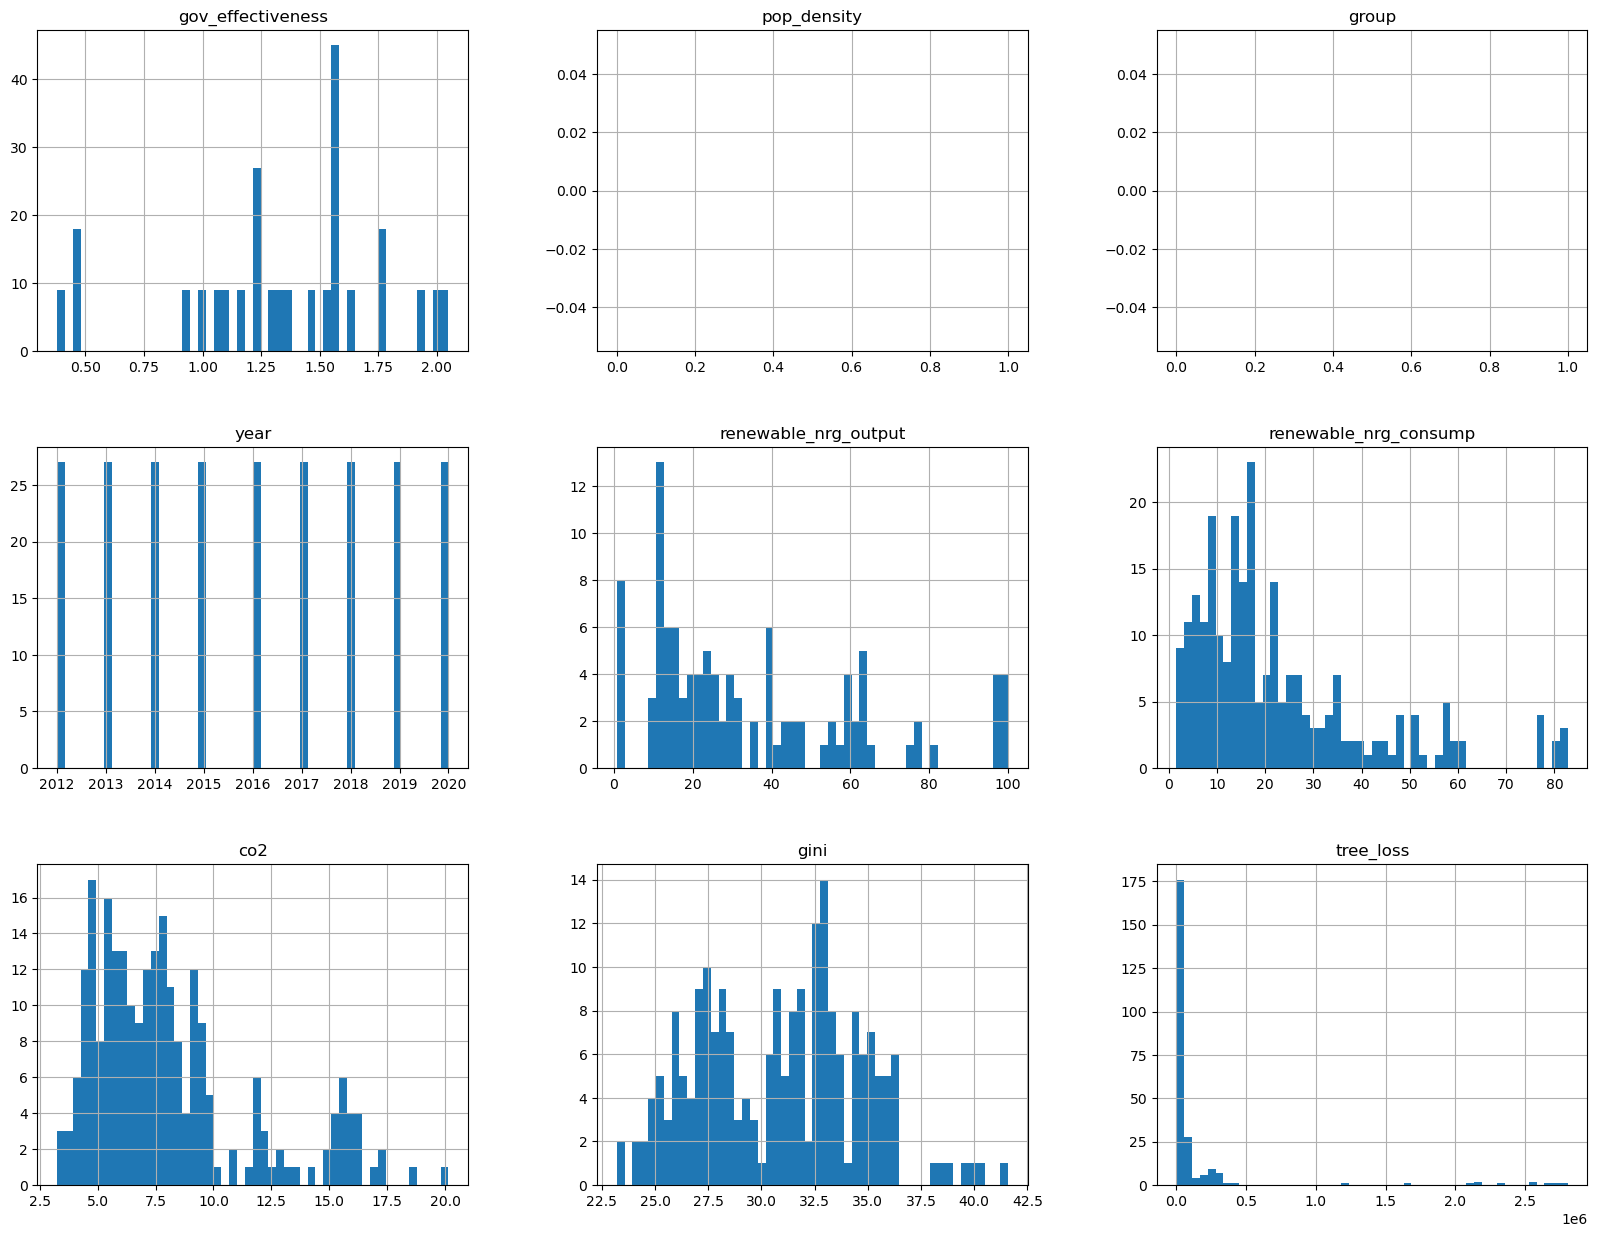

In [348]:
developed.hist(bins=50, figsize=(20, 15));

In [350]:
nearest = alt.selection_point(nearest=True, on='mouseover',
                        fields=['year'])

line = alt.Chart(developed).mark_line(strokeWidth=3).encode(
    alt.X('year:T', title = 'Year'),
    y='co2',
    color=alt.Color('country_name:N', legend=alt.Legend(title='Country'))
)

selectors = alt.Chart(developed).mark_point().encode(
    x='year:T',
    opacity=alt.value(0)
)

selectors_near = selectors.encode(
    opacity=alt.condition(nearest, alt.value(0.5), alt.value(0.3))
).add_params(nearest)

points = line.mark_circle().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
    tooltip=['country_name'] 
).add_params(nearest)

text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'co2:Q', alt.value(' '))
)

vertical_line = alt.Chart().mark_rule(color='gray').encode(
    x='year:T',
).transform_filter(
    alt.FieldEqualPredicate(field='year', equal=2016)
)

rules = alt.Chart(developed).mark_rule(color='gray').encode(
    x='year:T',
).transform_filter(
    nearest
)

layers = alt.layer(
    line, selectors, points, text, rules, vertical_line
).properties(
    width=1500, height=1000,
    title = "Total CO2 emissions for OECD Countries from 2012 to 2020"
).configure_title(
    fontSize=40
).configure_legend(
    symbolSize=200  # Adjust legend symbol size as needed
)

layers

alt.LayerChart(...)

In [351]:
developed_2016 = developed[developed['year']== 2016]

chart = alt.Chart(developed_2016).mark_circle(size = 400).encode(
    alt.X('co2:Q'),
    alt.Y('gini:Q', scale=alt.Scale(domain=[22, 40])),				
    alt.Color('country_name:N'),
    alt.Tooltip('country_name:N')
).properties(
    width=1500, height=1000,
    title = "Scatterplot of OECD Country Co2 emissions vs. Gini Coefficients in 2016 for Developed Countries"
).configure_title(
    fontSize=40
)
chart

alt.Chart(...)

In [352]:
df_2016 = developed[developed['year'] == 2016]
df_2020 = developed[developed['year'] == 2020]

# Concatenate DataFrames
comp_df = pd.concat([df_2016, df_2020])

# Plot using Altair
chart = alt.Chart(comp_df).mark_bar().encode(
    x=alt.X('country_name:N', title='Country', sort='-y'),
    y='co2:Q',
    column='year:N',  # Stagger bars based on year
    color='year:N',
    tooltip=['country_name', 'co2', 'year']
).properties(
    width=800,
    height=500,
    title='Absolute CO2 Levels by Country for 2016 and 2020'
).configure_title(
    fontSize=40
)
chart


alt.Chart(...)

In [357]:
developed_2016 = developed[developed['year'] == 2016]
developed_2020 = developed[developed['year'] == 2020]

merged_df = pd.merge(developed_2016, developed_2020, on=['country_name', 'country_code'], suffixes=('_2016', '_2020'))

merged_df['co2_percentage_change'] = ((merged_df['co2_2020'] - merged_df['co2_2016']) / merged_df['co2_2016']) * 100

result_df = merged_df[['country_name', 'country_code', 'co2_percentage_change']]

chart = alt.Chart(result_df).mark_bar().encode(
    x=alt.X('country_name:N', title='Country', sort='y'),  # Sort countries by co2_difference in descending order
    y=alt.Y('co2_percentage_change:Q', title='% Change in CO2 from 2016 to 2020'),
    color=alt.condition(
        alt.datum.co2_percentage_change > 0,
        alt.value('red'),  # Positive difference
        alt.value('green')  # Negative difference
    )
).properties(
    width=1000,
    height=500,
    title='% Change in CO2 Emissions (2016-2020) for OECD Countries Post-Treaty'
)

# Add horizontal line at y=0
horizontal_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black').encode(y='y')

# Combine chart and horizontal line
combined_chart = (chart + horizontal_line).configure_title(
    fontSize=40  # 
)

combined_chart

alt.LayerChart(...)

In [358]:
#ID all subgroups of population for analysis
complete

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
20,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN,2012.0,No,60.799484,49.47,0.947583,NaN,180755.0
21,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN,2013.0,No,58.020935,47.95,1.031044,NaN,168841.0
22,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN,2014.0,No,53.175105,48.27,1.091497,NaN,212662.0
23,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN,2015.0,No,53.174928,47.84,1.125185,NaN,161719.0
24,AGO,Angola,Sub-Saharan Africa,Luanda,Lower middle income,-1.040429,NaN,Developing,NaN,2016.0,No,NaN,49.03,1.012552,NaN,229710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,ZMB,Zambia,Sub-Saharan Africa,Lusaka,Lower middle income,-0.658233,NaN,Developing,NaN,2016.0,No,NaN,83.07,0.316995,NaN,141637.0
2985,ZMB,Zambia,Sub-Saharan Africa,Lusaka,Lower middle income,-0.658233,NaN,Developing,NaN,2017.0,No,NaN,81.89,0.393726,NaN,162681.0
2986,ZMB,Zambia,Sub-Saharan Africa,Lusaka,Lower middle income,-0.658233,NaN,Developing,NaN,2018.0,No,NaN,81.87,0.440527,NaN,143944.0
2987,ZMB,Zambia,Sub-Saharan Africa,Lusaka,Lower middle income,-0.658233,NaN,Developing,NaN,2019.0,No,NaN,81.48,0.414336,NaN,124641.0


In [ ]:
low_income = complete[complete['income_group'] == "Low income"]
low_income['country_code'].nunique()

developed_2016 = low_income[low_income['year'] == 2016]
developed_2020 = low_income[low_income['year'] == 2020]

merged_df = pd.merge(developed_2016, developed_2020, on=['country_name', 'country_code'], suffixes=('_2016', '_2020'))

merged_df['co2_percentage_change'] = ((merged_df['co2_2020'] - merged_df['co2_2016']) / merged_df['co2_2016']) * 100

result_df = merged_df[['country_name', 'country_code', 'co2_percentage_change']]

chart = alt.Chart(result_df).mark_bar().encode(
    x=alt.X('country_name:N', title='Country', sort='y'),  # Sort countries by co2_difference in descending order
    y=alt.Y('co2_percentage_change:Q', title='% Change in CO2 from 2016 to 2020'),
    color=alt.condition(
        alt.datum.co2_percentage_change > 0,
        alt.value('red'),  # Positive difference
        alt.value('green')  # Negative difference
    )
).properties(
    width=1000,
    height=500,
    title='% Change in CO2 Emissions (2016-2020) for OECD Countries Post-Treaty'
)

# Add horizontal line at y=0
horizontal_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black').encode(y='y')

# Combine chart and horizontal line
combined_chart = (chart + horizontal_line).configure_title(
    fontSize=40  # 
)

combined_chart

In [383]:
developing_2016 = developing[developing['year'] == 2016]
developing_2020 = developing[developing['year'] == 2020]

# Concatenate DataFrames
comp_df = pd.concat([developing_2016, developing_2020])

# Plot using Altair
chart = alt.Chart(comp_df).mark_bar().encode(
    x=alt.X('country_name:N', title='Country', sort='-y'),
    y='co2:Q',
    column='year:N',  # Stagger bars based on year
    color='year:N',
    tooltip=['country_name', 'co2', 'year']
).properties(
    width=800,
    height=500,
    title='Absolute CO2 Levels by Country for 2016 and 2020'
).configure_title(
    fontSize=40
)
chart


alt.Chart(...)

In [382]:
developing_2016 = developing[developing['year'] == 2016]
developing_2020 = developing[developing['year'] == 2020]

merged_df = pd.merge(developing_2016, developing_2020, on=['country_name', 'country_code'], suffixes=('_2016', '_2020'))

merged_df['co2_percentage_change'] = ((merged_df['co2_2020'] - merged_df['co2_2016']) / merged_df['co2_2016']) * 100

result_df = merged_df[['country_name', 'country_code', 'co2_percentage_change']]

chart = alt.Chart(result_df).mark_bar().encode(
    x=alt.X('country_name:N', title='Country', sort='y'),  # Sort countries by co2_difference in descending order
    y=alt.Y('co2_percentage_change:Q', title='% Change in CO2 from 2016 to 2020'),
    color=alt.condition(
        alt.datum.co2_percentage_change > 0,
        alt.value('red'),  # Positive difference
        alt.value('green')  # Negative difference
    )
).properties(
    width=1000,
    height=500,
    title='% Change in CO2 Emissions (2016-2020) for Developing Countries Post-Treaty'
)

# Add horizontal line at y=0
horizontal_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black').encode(y='y')

# Combine chart and horizontal line
combined_chart = (chart + horizontal_line).configure_title(
    fontSize=40  # 
)

combined_chart

alt.LayerChart(...)

In [359]:
complete['income_group'].unique()

array(['Lower middle income', 'Upper middle income',
       'High income: nonOECD', 'High income: OECD', 'Low income'],
      dtype=object)

In [363]:
complete['region'].unique()

array(['Sub-Saharan Africa', 'Europe & Central Asia',
       'Middle East & North Africa', 'Latin America & Caribbean',
       'East Asia & Pacific', 'South Asia', 'North America'], dtype=object)

In [379]:
low_mid_income = complete[complete['income_group'] == "Lower middle income"]
low_mid_income['country_code'].nunique()

41

In [374]:
upper_middle_income = complete[complete['income_group'] == "Upper middle income"]
upper_middle_income['country_code'].nunique()

36

In [377]:
high_income_nonOECD = complete[complete['income_group'] == "High income: nonOECD"]
high_income_nonOECD['country_code'].nunique()

4

In [378]:
high_income_OECD = complete[complete['income_group'] == "High income: OECD"]
high_income_OECD['country_code'].nunique()

30

In [ ]:
high_income_OECD = complete[complete['income_group'] == "High income: OECD"]
high_income_OECD['country_code'].nunique()

In [ ]:
# Does having a renewable NRG target ...


# Investigating Pre-trends

In [268]:
### Which countries were making the most work in cutting down their CO2 emissions prior to the treaty? Is this correlated with post-treaty progress on Co2 emissions?
complete_pretrends = complete[(complete['year'] >= 2012) & (complete['year'] <= 2016)]
complete['year'] = complete['year'].astype(float)
complete

,country_code,country_name,region,Capital City,income_group,gov_effectiveness,pop_density,econ_status,group,year,target,renewable_nrg_output,renewable_nrg_consump,co2,gini,tree_loss
116,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2012.0,Yes,10.592653,8.30,17.405618,NaN,139803.0
117,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2013.0,Yes,13.264108,9.22,16.794588,NaN,260094.0
118,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2014.0,Yes,14.906712,9.33,16.155745,34.4,281737.0
119,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2015.0,Yes,13.637841,9.32,16.198458,NaN,261571.0
120,AUS,Australia,East Asia & Pacific,Canberra,High income: OECD,1.528875,NaN,Developed,NaN,2016.0,Yes,NaN,9.36,16.320331,33.7,430899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2016.0,Yes,NaN,50.89,3.899110,29.6,310348.0
2553,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2017.0,Yes,NaN,51.82,3.794924,28.8,331217.0
2554,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2018.0,Yes,NaN,51.56,3.529744,30.0,290151.0
2555,SWE,Sweden,Europe & Central Asia,Stockholm,High income: OECD,1.572977,NaN,Developed,NaN,2019.0,Yes,NaN,52.87,3.401594,29.3,332891.0


In [269]:
complete_pretrends = complete.loc[:, ['country_code', 'country_name', 'year', 'co2']]
complete_pretrends

,country_code,country_name,year,co2
116,AUS,Australia,2012.0,17.405618
117,AUS,Australia,2013.0,16.794588
118,AUS,Australia,2014.0,16.155745
119,AUS,Australia,2015.0,16.198458
120,AUS,Australia,2016.0,16.320331
...,...,...,...,...
2552,SWE,Sweden,2016.0,3.899110
2553,SWE,Sweden,2017.0,3.794924
2554,SWE,Sweden,2018.0,3.529744
2555,SWE,Sweden,2019.0,3.401594


## Are developed countries doing better relative to developing countries in reducing CO2 emissions?

# EDA

# Statistical Analysis

In [226]:
X = complete_pretrends['year']
y = complete_pretrends['co2']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.881
Date:                Thu, 21 Mar 2024   Prob (F-statistic):              0.171
Time:                        13:43:42   Log-Likelihood:                -1667.6
No. Observations:                 612   AIC:                             3339.
Df Residuals:                     610   BIC:                             3348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.5633    116.683      1.410      0.1